# In this notebook I'll try to predict flight delay using perceptron neural network and compare it to other ML models (random forest)

Flight delay is defined by 15 min or more.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# load data
df = pd.read_csv('flight_delays_train.csv')
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


EDA

In [3]:
df.dtypes

Month                object
DayofMonth           object
DayOfWeek            object
DepTime               int64
UniqueCarrier        object
Origin               object
Dest                 object
Distance              int64
dep_delayed_15min    object
dtype: object

In [4]:
df['Month'].unique()

array(['c-8', 'c-4', 'c-9', 'c-11', 'c-10', 'c-1', 'c-7', 'c-6', 'c-5',
       'c-3', 'c-12', 'c-2'], dtype=object)

In [5]:
df.isnull().sum()

Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
UniqueCarrier        0
Origin               0
Dest                 0
Distance             0
dep_delayed_15min    0
dtype: int64

There no missing values, which is good. <br> 
I'll remove the 'c-' from month, day of the week and day of the month and cast it to int

In [6]:
for col in ['Month', 'DayofMonth', 'DayOfWeek']:
    df[col] = df[col].str.strip('c-')
    df[col] = pd.to_numeric(df[col])
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
Month                100000 non-null int64
DayofMonth           100000 non-null int64
DayOfWeek            100000 non-null int64
DepTime              100000 non-null int64
UniqueCarrier        100000 non-null object
Origin               100000 non-null object
Dest                 100000 non-null object
Distance             100000 non-null int64
dep_delayed_15min    100000 non-null object
dtypes: int64(5), object(4)
memory usage: 6.9+ MB


[]

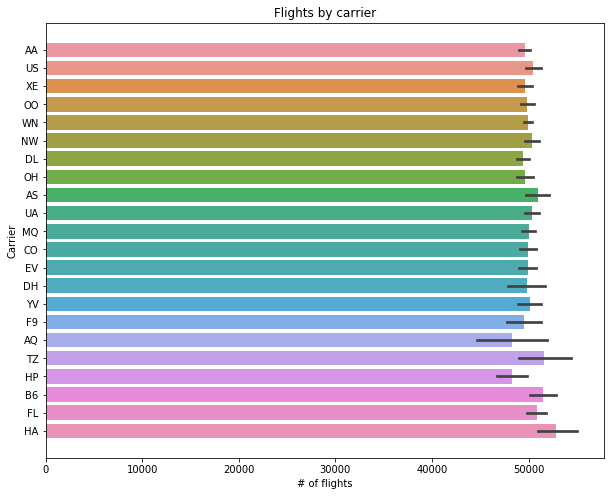

In [7]:
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x = df['UniqueCarrier'].index, y = df['UniqueCarrier'])
plt.title('Flights by carrier')
plt.ylabel('Carrier')
plt.xlabel('# of flights')
plt.plot()

Text(0.5, 1.0, 'Flights distance distribution')

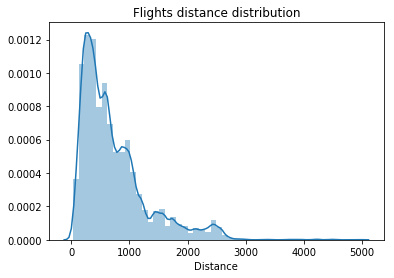

In [8]:
# hist of the distance
sns.distplot(df['Distance'])
plt.title('Flights distance distribution')

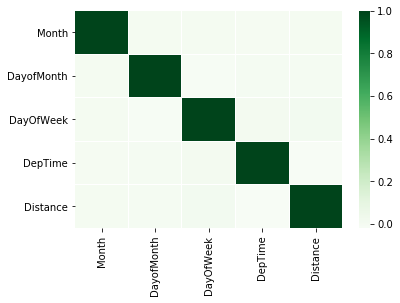

In [9]:
# check correlations
corr = df.corr()
sns.heatmap(corr, linewidths=0.01, cmap='Greens')

In [10]:
print("There are {} unique origins and {} unique destinations in the data set".format(df['Origin'].nunique(), df['Dest'].nunique()))

There are 289 unique origins and 289 unique destinations in the data set


In [11]:
# don't want to train with that size, so I'll keep the 10 most popular places
# for origin
short_org = df['Origin'].value_counts()
short_org = short_org[:20]

short_dst = df['Dest'].value_counts()
short_dst = short_org[:20]

In [12]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,N
1,4,20,3,1548,US,PIT,MCO,834,N
2,9,2,5,1422,XE,RDU,CLE,416,N
3,11,25,6,1015,OO,DEN,MEM,872,N
4,10,7,6,1828,WN,MDW,OMA,423,Y


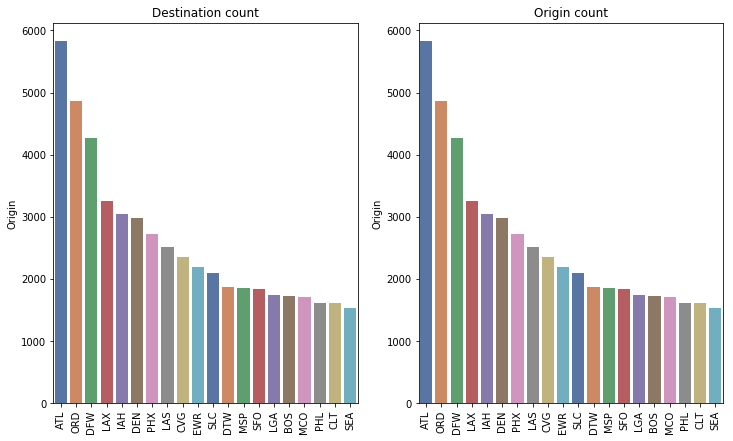

In [13]:
f, ax = plt.subplots(figsize=(12, 7))

plt.subplot(1,2,1)
sns.barplot(x=short_dst.index, y=short_dst, palette='deep')
plt.xticks(rotation='90')
plt.title('Destination count')

plt.subplot(1,2,2)
sns.barplot(x=short_org.index, y=short_org, palette='deep')
plt.xticks(rotation='90')
plt.title('Origin count')

plt.show()

In [14]:
# keep only the rows that their destination or origin is from the list (the 10 most visited cities)
top_cities = list(short_dst.index)
reduced_df = df[df['Dest'].isin(top_cities) & df['Origin'].isin(top_cities)]
reduced_df.shape

(20481, 9)

In [15]:
# make target binary and change name
reduced_df['Delayed'] = np.where(reduced_df['dep_delayed_15min'] == 'Y', 1, 0)
# remove old column
reduced_df = reduced_df.drop('dep_delayed_15min', axis=1)

# reset index
reduced_df = reduced_df.reset_index(drop=True)

reduced_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Delayed
0,8,21,7,1934,AA,ATL,DFW,732,0
1,4,29,6,635,OH,MSP,CVG,596,0
2,10,6,4,2124,AS,LAS,SEA,866,0
3,10,14,5,1704,OO,SLC,SEA,689,1
4,8,22,2,1521,AA,CLT,DFW,936,0


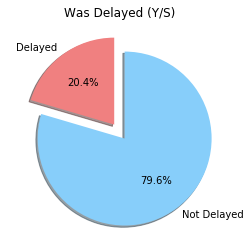

In [16]:
labels = 'Delayed', 'Not Delayed'
sizes = [(reduced_df['Delayed'] == 1).sum(), (reduced_df['Delayed'] == 0).sum()]
colors = ['lightcoral', 'lightskyblue' ]

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90, explode=(0.1,0.1))

plt.title('Was Delayed (Y/S)')
plt.show()

In [17]:
# make dummies
new_df = pd.get_dummies(reduced_df)
new_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,Distance,Delayed,UniqueCarrier_AA,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,...,Dest_LAX,Dest_LGA,Dest_MCO,Dest_MSP,Dest_ORD,Dest_PHL,Dest_PHX,Dest_SEA,Dest_SFO,Dest_SLC
0,8,21,7,1934,732,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,29,6,635,596,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,6,4,2124,866,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,10,14,5,1704,689,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,8,22,2,1521,936,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# split to X and y
X = new_df.drop('Delayed', axis=1)
y = new_df['Delayed']

## Start with Multi Layer Perceptron (MLP) classifier
first I'll try two layers with different solvers<br>
I'll then compare it to a random forest classifier <br>
Next, I'll try several different layers and parameters for the MLP and compare again

In [19]:
# create the first model w/ two layers
# solver = 'adam' (stochastic gradient-based optimizer)
mlp1 = MLPClassifier(hidden_layer_sizes=(100,5), solver='adam')

mlp_s1 = cross_val_score(mlp1, X, y, cv=5)
print("Scores:\n{} \n Mean: {}; STD: {}".format(mlp_s1, mlp_s1.mean(), mlp_s1.std()))

Scores:
[0.79546009 0.79546009 0.7956543  0.7956543  0.7970696 ] 
 Mean: 0.7958596752642366; STD: 0.0006111634332512345


In [20]:
# solver = 'sgd' (stochastic gradient descent)
mlp2 = MLPClassifier(hidden_layer_sizes=(100,5), solver='sgd')

mlp_s2 = cross_val_score(mlp2, X, y, cv=5)
print("Scores:\n{} \n Mean: {}; STD: {}".format(mlp_s2, mlp_s2.mean(), mlp_s2.std()))

Scores:
[0.79546009 0.79546009 0.7956543  0.7956543  0.7956044 ] 
 Mean: 0.7955666349711963; STD: 8.887921425555793e-05


In [21]:
# solver = lbfgs (optimizer in the family of quasi-Newton methods)
mlp3 = MLPClassifier(hidden_layer_sizes=(100,5), solver='lbfgs')

mlp_s3 = cross_val_score(mlp3, X, y, cv=5)
print("Scores:\n{} \n Mean: {}; STD: {}".format(mlp_s3, mlp_s3.mean(), mlp_s3.std()))

Scores:
[0.79546009 0.75298999 0.7956543  0.42724609 0.7956044 ] 
 Mean: 0.7133909743315515; STD: 0.14401987085703394


In [22]:
# compare to random forest classifier
rtree1 = RandomForestClassifier(n_estimators=100, max_depth=5)

rtree_s1 = cross_val_score(rtree1, X, y, cv=5)
print("Scores:\n{} \nMean: {}; STD: {}".format(rtree_s1, rtree_s1.mean(), rtree_s1.std()))

Scores:
[0.79546009 0.79546009 0.7956543  0.7956543  0.7956044 ] 
Mean: 0.7955666349711963; STD: 8.887921425555793e-05


After running it, I get that solver = sgd performs the best out of the other MLPs with a mean score of 0.7956 and std of 8.89 * 10^-5. Weirdly enough random forest has exact same score (for each cross-fold and mean and std) <br>
Next. change some parameters for this model and compare it again

In [23]:
# three layers 
mlp = MLPClassifier(hidden_layer_sizes=(100,20,10), solver='sgd')

mlp_s = cross_val_score(mlp, X, y, cv=5)
print("Scores:\n{} \n Mean: {}; STD: {}".format(mlp_s, mlp_s.mean(), mlp_s.std()))

Scores:
[0.79546009 0.79546009 0.7956543  0.7956543  0.7956044 ] 
 Mean: 0.7955666349711963; STD: 8.887921425555793e-05


In [24]:
# three layers 
mlp = MLPClassifier(hidden_layer_sizes=(100,20,10), solver='sgd', activation='logistic', alpha=0.005, learning_rate='adaptive')

mlp_s = cross_val_score(mlp, X, y, cv=5)
print("Scores:\n{} \n Mean: {}; STD: {}".format(mlp_s, mlp_s.mean(), mlp_s.std()))

Scores:
[0.79546009 0.79546009 0.7956543  0.7956543  0.7956044 ] 
 Mean: 0.7955666349711963; STD: 8.887921425555793e-05


In [25]:
# four layers 
mlp = MLPClassifier(hidden_layer_sizes=(100,50,25,10), solver='sgd')

mlp_s = cross_val_score(mlp, X, y, cv=7)
print("Scores:\n{} \n Mean: {}; STD: {}".format(mlp_s, mlp_s.mean(), mlp_s.std()))

Scores:
[0.7953536  0.79562543 0.79562543 0.79562543 0.79562543 0.79555556
 0.79555556] 
 Mean: 0.7955666320430982; STD: 9.215952729972367e-05
